

<font size = "5"> **Chapter 2:  [Imaging](Ch3-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Registration of Images in a Stack 

part of 

<font size = "5"> **[Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)**</font>


by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## First we import the usual libraries
Please visit the  section for [pyTEMlib](Ch1-Prerequesites.ipynb#TEM_Library) of the [Prerequesites](Ch1-Prerequesites.ipynb) section for information of necessary packages.

You'll need at least pyTEMlib version 0.7.2019.0

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:    
    %pylab --no-import-all notebook
    
import warnings
warnings.filterwarnings('ignore')

import scipy.constants

# Import libraries from the book
import pyTEMlib
import pyTEMlib.KinsCat as ks

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = '2_Image_Registration'
__notebook_version__ = '2020_06_27'

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2021.03.02



## Weak Phase Object

the simplest approximation is for the sample to be very thin and then then the incident electrons pass through the specimen with only small
deviations in their paths, which can be approximated by a phase change only.
These influeces of a specimen can be modeled as a simple
transmission function $t (x)$. The electron wave function after passing through the
specimen is:
$$
\Psi_t(x) = t(x) \Psi_{inc}(x)
$$

with $\Psi_{inc}$:incident wave  function

This transmisison function is the same that we used for a thin slice in  the multislice algorithm.
So we approximate here a sample by a thin slice.

The exit wave is then distorted by the aberration function $\chi(\vec{k})$ of the objective lens.
Because this distortion function is defined in reciprocal space it is convenient to address the image distortion as a convolution. We descibe this effect of the objective lens as shifts to the phase of each frequency component by a different amount according to the aberration function $\chi(\vec{k})$. this convolution is a multiplicaiton in Fourier Space. 

## Projected Potential of Supercell
As in the Dynamic Diffraction part in the [Multislice notebook](../Diffraction/CH2_D02-Multislice.ipynb), we first define a potential.

Here we make a non-realistic silicon crystal.

<IPython.core.display.Javascript object>


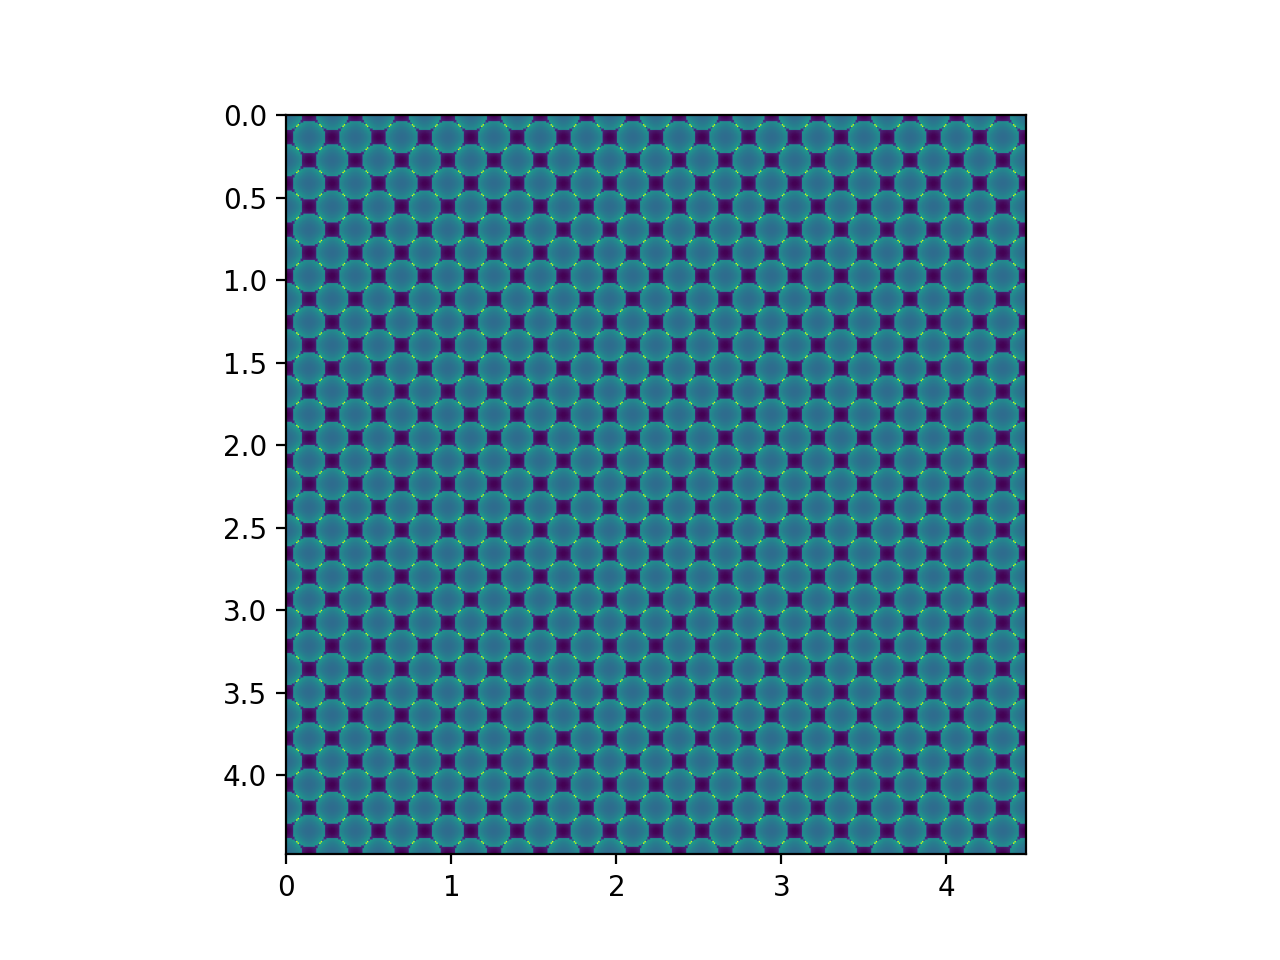

In [2]:
def potential_1D(element, r, dx):
    # atomic_number.append(electronFF[tags['elements'][i]]['Z'])
    a0 = scipy.constants.value('Bohr radius') * 1e10
    e0 = scipy.constants.elementary_charge
    dx = dx * 10
    r = r * 10
    
    pre_factor = 2 * np.pi ** 2 * a0 * e0

    param = ks.electronFF[element]  # parametrized form factors
    fL = r*0  # Lorentzian term
    fG = r*0  # Gaussian term
    for i in range(3):
        fL += param['fa'][i] * scipy.special.k0(2 * np.pi * r * np.sqrt(param['fb'][i]))
        fG += param['fc'][i] / param['fd'][i] * np.exp(-np.pi**2 * r**2 / param['fd'][i])

       
    return pre_factor * (2 * fL + fG)

def potential_2D(element, nx, ny, n_cell_x, n_cell_y, lattice_parameter, base):
    n_cell_x = int(2**np.log2(n_cell_x))
    n_cell_y = int(2**np.log2(n_cell_y))
    
    pixel_size = lattice_parameter/(nx/n_cell_x)
    
    a_nx = a_ny = int(1/pixel_size)
    x,y = np.mgrid[0:a_nx, 0:a_ny] * pixel_size
    a = int(nx/n_cell_x)
    r = x**2+y**2 
    r[r<pixel_size] = pixel_size/4
    atom_potential = potential_1D(element, r, 0.02)

    potential = np.zeros([nx,ny])

    atom_potential_corner = np.zeros([nx,ny])
    atom_potential_corner[0:a_nx, 0:a_ny] = atom_potential
    atom_potential_corner[nx-a_nx:,0:a_ny] = np.flip(atom_potential, axis=0)
    atom_potential_corner[0:a_nx,ny-a_ny:] = np.flip(atom_potential, axis=1)
    atom_potential_corner[nx-a_nx:,ny-a_ny:] = np.flip(np.flip(atom_potential, axis=0), axis=1)

    unit_cell_base = np.array(base)*a
    unit_cell_base = np.array(unit_cell_base, dtype= int)
    

    for pos in unit_cell_base:
        potential = potential + np.roll(atom_potential_corner, shift=np.array(pos), axis = [0,1])
    
    for column in range(int(np.log2(n_cell_x))):
        potential = potential + np.roll(potential, shift = 2**column * a, axis = 1)
    for row in range(int(np.log2(n_cell_y))):
        potential = potential + np.roll(potential, shift = 2**row * a, axis = 0)
            
    return potential

nx = ny = 512
n_cell_x = 16
a = 0.28

potential = potential_2D('Si', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)
plt.figure()
plt.imshow((potential), extent=[0,nx*pixel_size, ny*pixel_size, 0 ])

## Transmission Function for Very Thin Specimen

For a very thin specimen the ``weak phase approximation`` is the simples way to calculate a high resolution (phase contrast) image.  
In that approximation, the sample causes only a phase change to the incident plane wave.


To retrieve the exit we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

<IPython.core.display.Javascript object>


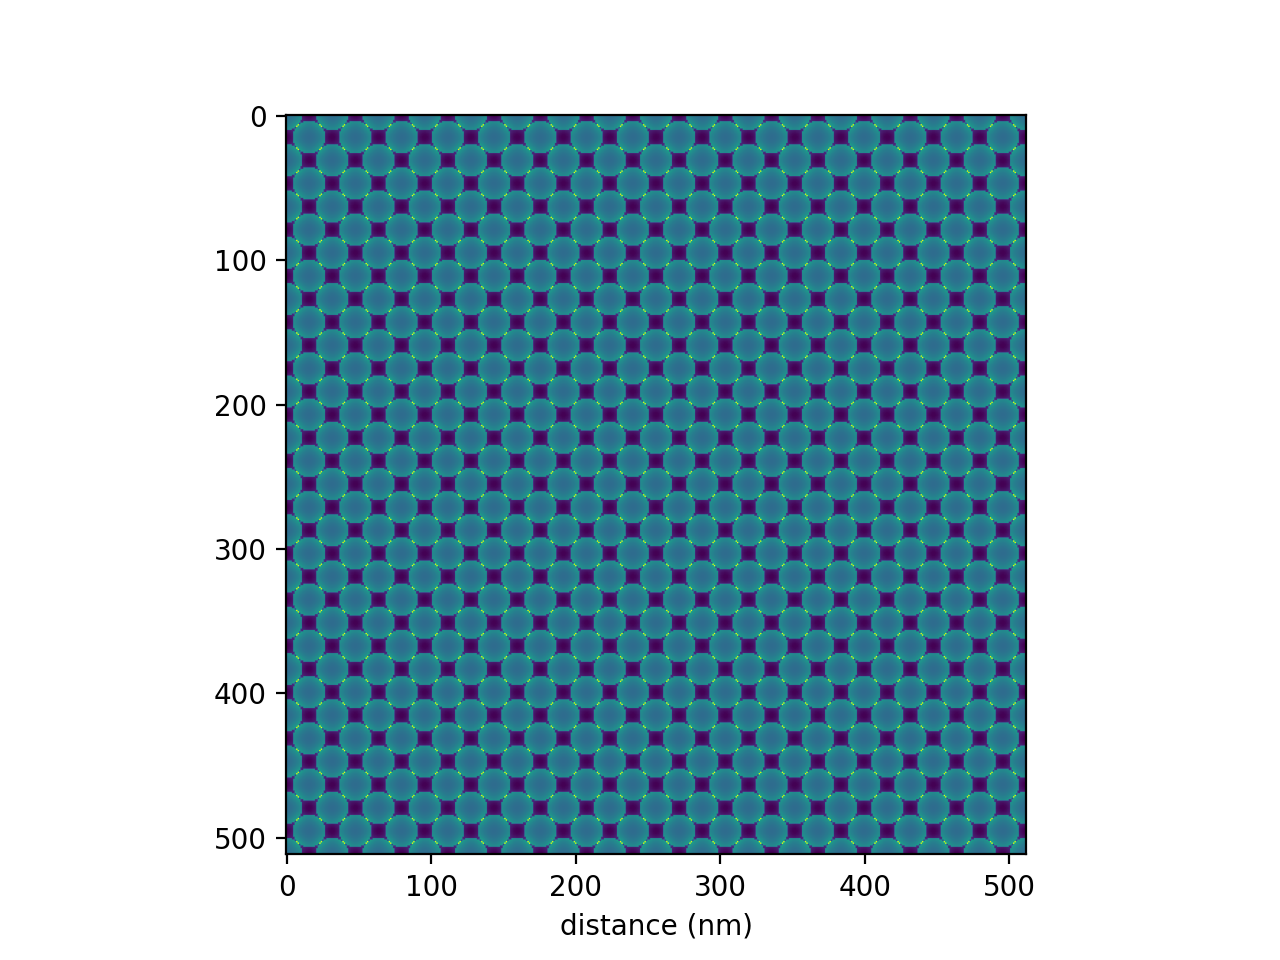

Text(0.5, 0, 'distance (nm)')

In [3]:
def interaction_parameter(acceleration_voltage):
    """Calculates interaction parameter sigma
    
    Parameter
    ---------
    acceleration_voltage: float
        acceleration voltage in volt
    
    Returns
    -------
    interaction parameter: float
        interaction parameter (dimensionless)
    """
    V = acceleration_voltage # in eV
    E0 = 510998.95 #  m_0 c^2 in eV
    
    wavelength = ks.get_wavelength(acceleration_voltage)
    E = acceleration_voltage
    
    return 2*np.pi/ (wavelength * E)  *(E0 + E)/(2*E0+E)



def get_transmission(sigma, potential):
    
    t = np.exp(1j*sigma* potential)
    return t
    
acceleration_voltage = 200000

sigma = interaction_parameter(acceleration_voltage)
transmission = get_transmission(sigma, potential)

plt.figure()
plt.imshow(transmission.imag)#, extent = image_extent)
plt.xlabel('distance (nm)')



Please note that there is no effect by multiplying with a plane wave

<IPython.core.display.Javascript object>


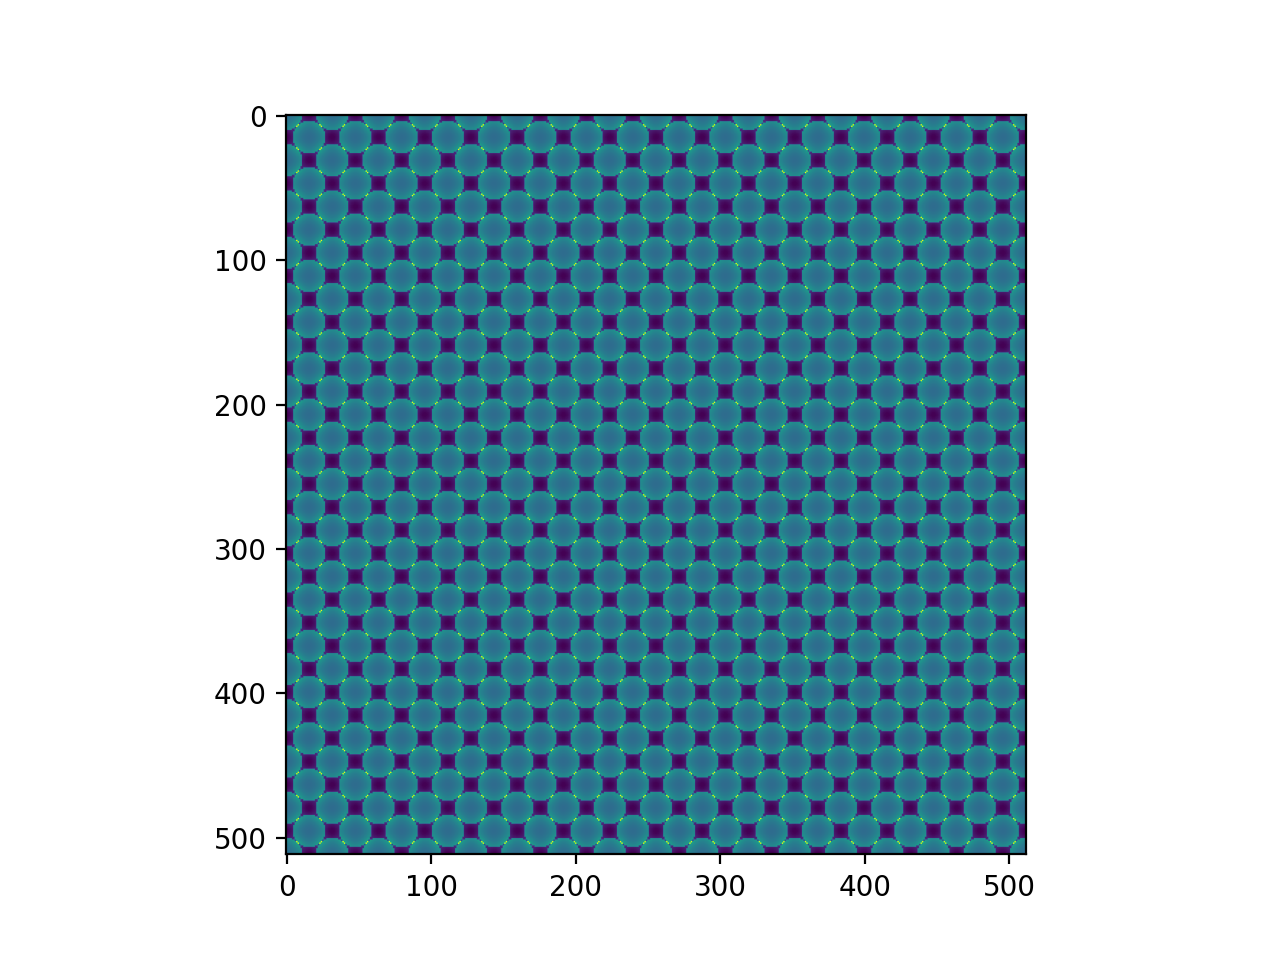

In [4]:
plane_wave = np.ones([nx,ny], dtype=complex)

exit_wave = plane_wave * transmission

plt.figure()
plt.imshow(np.abs(exit_wave.imag))

<IPython.core.display.Javascript object>


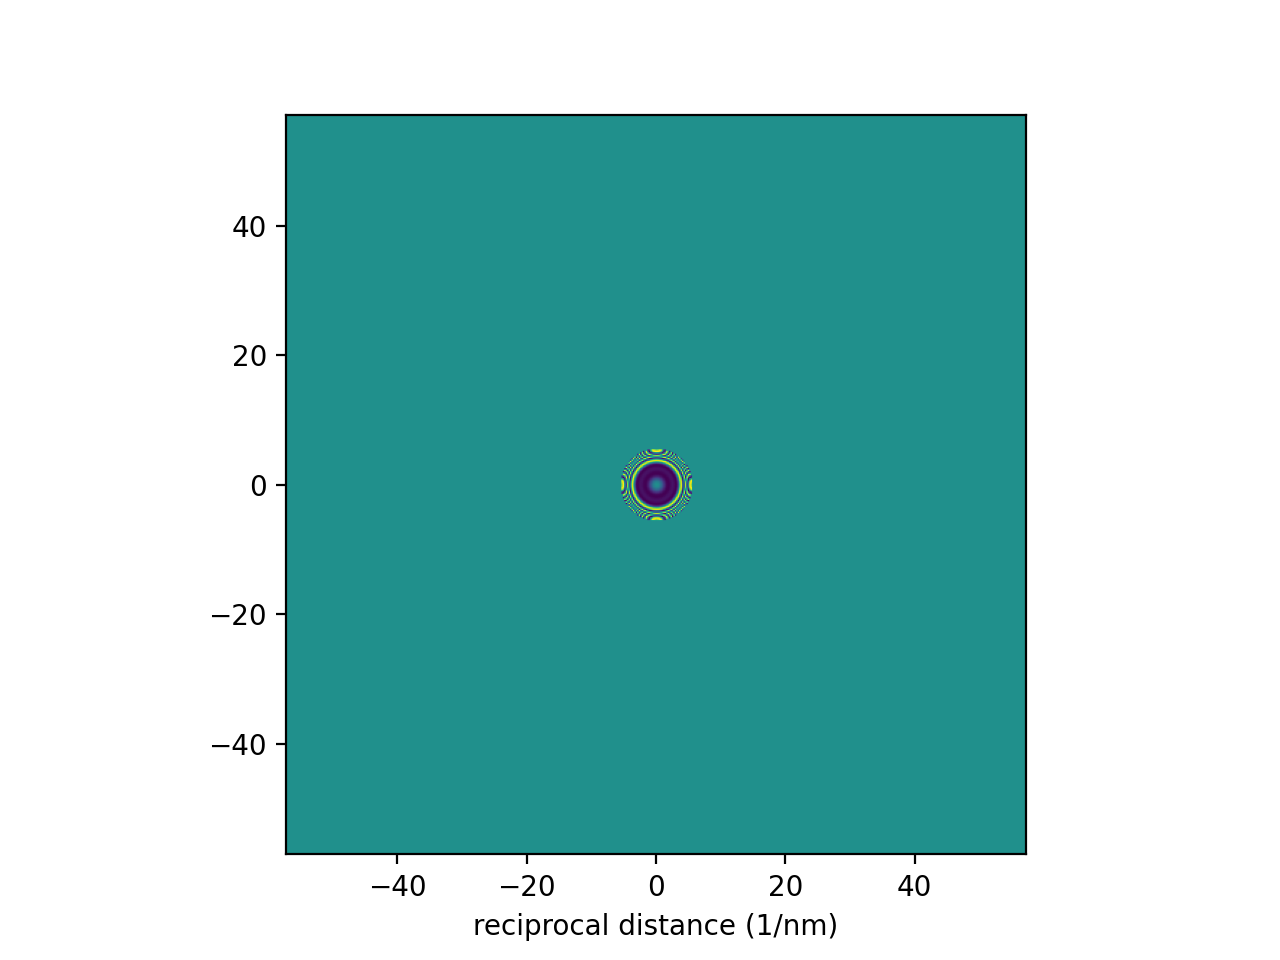

Text(0.5, 0, 'reciprocal distance (1/nm)')

In [5]:
def make_chi(theta, phi, wavelength, ab):
    """Calculate aberration function chi
    
    Input:
    ------
    theta, phi: numpay array (n x m)
        angle meshes of the reciprocal space
    wavelength: float
        wavelength in nm
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
        
    Returns:
    --------
    chi: numpy array (nxm)
        aberration function 
    """
    if 'C10' not in ab:
        ab['C10'] = 0.
    if 'C12a' not in ab:
        ab['C12a'] = 0.
    if 'C12b' not in ab:
        ab['C12b'] = 0.
    # defocus and astigmatism
    t1 = np.power(theta, 2)/2 * (ab['C10']  + ab['C12a'] * np.cos(2 * phi) + ab['C12b'] * np.sin(2 * phi))
    

    # coma and three fold astigmatism
    if 'C21a' in ab and 'C21b' in ab and 'C23a' in ab and 'C23b' in ab:
        t2 = np.power(theta, 3)/3 * (ab['C21a'] * np.cos(1*phi) + ab['C21b'] * np.sin(1*phi))
    else:
        t2 = theta*0.
    # spherical aberration
    if 'C30' not in ab:
        ab['C30'] = 0.
    t3 = np.power(theta, 4)/4 * ab['C30']
                              
    chi = t1 + t2+ t3
    return chi * 2 * np.pi / wavelength  # np.power(theta,6)/6*(  ab['C50'] )
                           
def objective_lens_function(ab, nx, ny, field_of_view, wavelength, aperture_size=10):
    """Objective len function to be convoluted with exit wave to derive image function
    
    Input:
    ab: dict
        aberrations in nm should at least contain defocus (C10), and spherical abeeration (C30) 
    nx: int
        number of pixel in x direction
    ny: int
        number of pixel in y direction
    field_of_view: float
        field of fiew of potential
    wavelength: float
        wavelength in nm
    aperture_size: float
        aperture size in 1/nm
        
    Returns:
    --------
    object function: numpy array (nx x ny)
    extent: list
    """
    
    # Reciprocal plane in 1/nm
    dk = 1 / field_of_view
    t_xv, t_yv = np.mgrid[int(-nx/2):int(nx/2),int(-ny/2):int(ny/2)] *dk

    # define reciprocal plane in angles
    phi = np.arctan2(t_yv, t_xv)
    theta = np.arctan2(np.sqrt(t_xv**2 + t_yv**2), 1/wavelength)

    mask = theta < aperture_size * wavelength

    # calculate chi
    chi = make_chi(theta, phi, wavelength, ab)
    
    extent = [-nx/2*dk, nx/2*dk, -nx/2*dk,nx/2*dk]
    return np.sin(chi)*mask, extent

acceleration_voltage = 200000
ab={'C10':-84.0, 'C12a':0.0, 'C12b':0.0, 'C30': 2.2*1e6} # aberrations in nm

wavelength = ks.get_wavelength(acceleration_voltage)

objective_lens, extent = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/.18)
plt.figure()
plt.imshow(objective_lens, extent=extent)
plt.xlabel('reciprocal distance (1/nm)')


## Image Simulation in Weak Phase Approximation

In the weak phase approximation the image is just the convoltuion of the transmission function and the objective lens funtion.

If an aperture selects only the inner smooth part of the objetive function in Scherzer defocus, the image is naively to interpret as the dark parts as the atoms (remember the CTF is negative in that case)

<IPython.core.display.Javascript object>


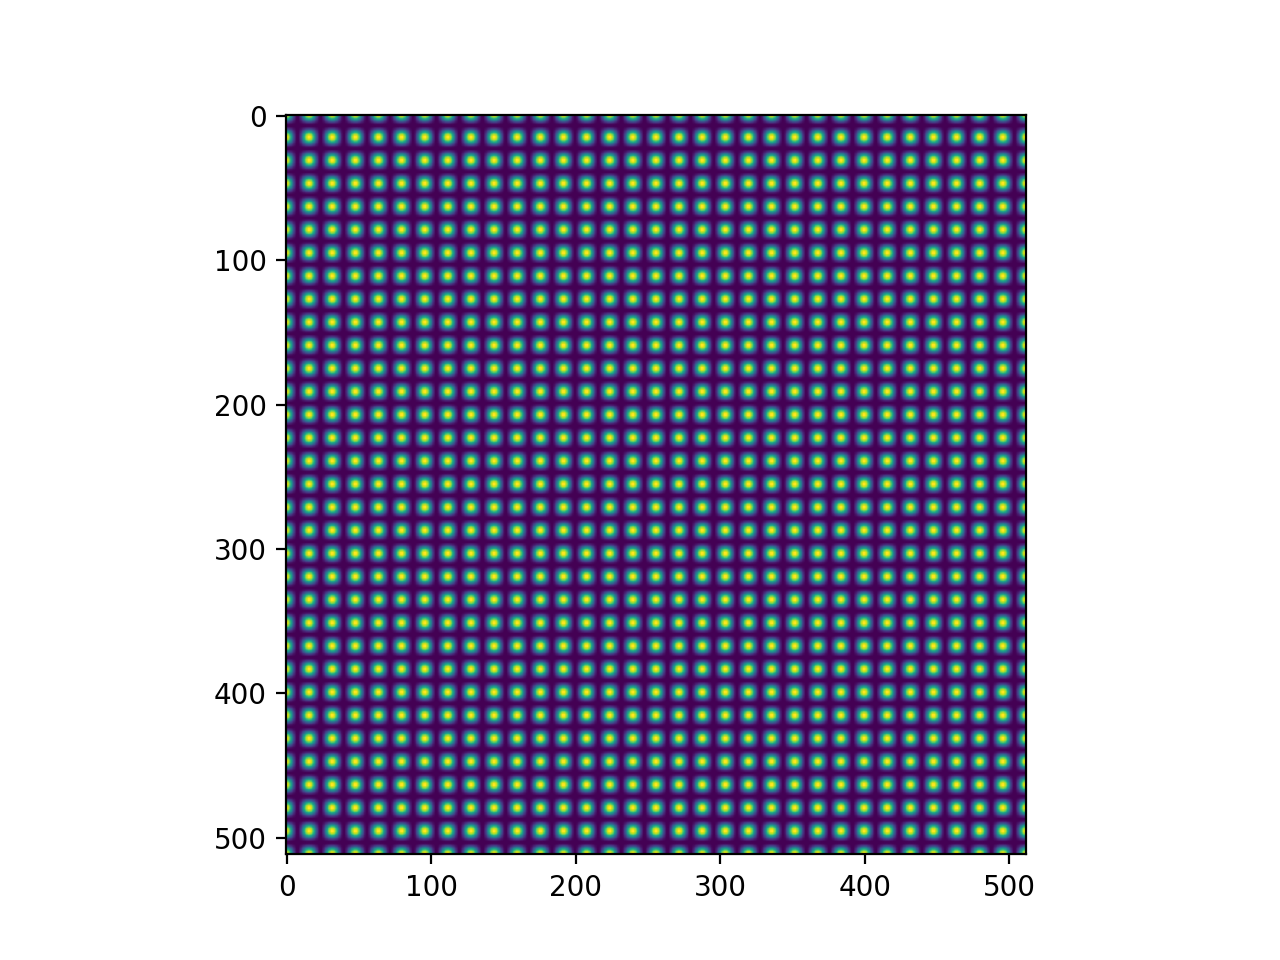

In [6]:

image = np.fft.ifft2((np.fft.fft2(transmission))*np.fft.fftshift(objective_lens))
plt.figure()
plt.imshow(np.abs(image*np.conjugate(image)))


## Influence of Aberrations on Image

Within this weak phase object aberration, we can already investigate the influence of lens aberrations on the image.

We do now all steps together and check the effect of the aberration, acceleration voltage, aperture, and element onto the final image (in weak phase approximation).



<IPython.core.display.Javascript object>


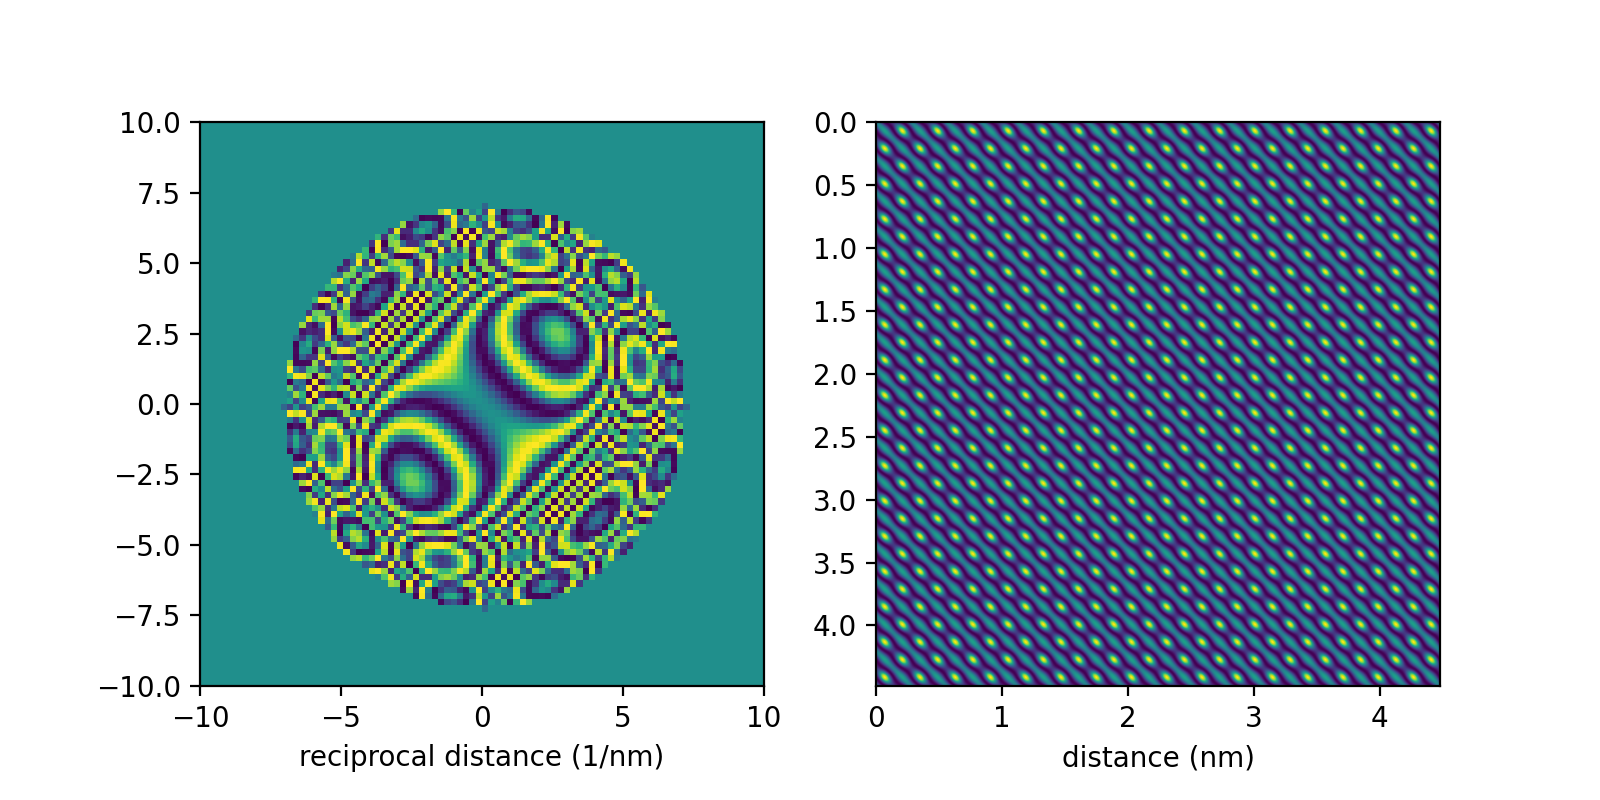

Text(0.5, 0, 'distance (nm)')

In [39]:
nx = ny = 1024
n_cell_x = 16
a = 0.28
acceleration_voltage = 200000
resolution = 0.14
ab={'C10':-88.0, 'C12a': 00.0, 'C12b': 100.0, 'C30': 2.2*1e6} # aberrations in nm

potential = potential_2D('Au', nx, nx, n_cell_x, n_cell_x, a, [[0,0], [0.5,0.5]])
pixel_size = a/(nx/n_cell_x)

sigma = interaction_parameter(acceleration_voltage)
t = get_transmission(sigma, potential)

wavelength = ks.get_wavelength(acceleration_voltage)

objective_lens, extent_r = objective_lens_function(ab, nx, nx, nx*pixel_size, wavelength, 1/resolution)

image = np.fft.ifft2((np.fft.fft2(t))*np.fft.fftshift(objective_lens))
image = np.abs(image*np.conjugate(image))

plt.close('all')
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(objective_lens, extent=extent_r)
ax[0].set_xlabel('reciprocal distance (1/nm)')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-10,10)

ax[1].imshow(image, extent=[0,nx*pixel_size, ny*pixel_size, 0 ])
ax[1].set_xlabel('distance (nm)')

## Summary


The weak phase object allows for a fast check on image parameters. For a quantitative image simulation we need to do dynamic scattering theory. Please go to the  [Defocus-Thickness notebook](CH3_05-Defocus_Thickness.ipynb)


In [20]:
# Calculating the total 2D potentials for each layer

def DefPot2DLayer(PixImageSize, ImageRange, NLayers, MatLattice, UnitCellPot2D, dx):
    Mat2D = MatLattice[:2,:2]
    Mat2DInv = np.linalg.inv(Mat2D)
    dnx = int(round(np.linalg.norm(Mat2D[0])/(dx)))
    dny = int(round(np.linalg.norm(Mat2D[0])/(dx)))
    nx = np.linspace(0, 1, dnx, endpoint=False)
    ny = np.linspace(0, 1, dny, endpoint=False)
    
    Pot2DLayer = np.array([[[0.  \
        for i in range(PixImageSize[0])] for j in range(PixImageSize[1])]  for k in range(NLayers)])


    for i in range(NLayers): # Layers loop
        Pot2DInter = interp2d(ny, nx, UnitCellPot2D[i])
        for ScanY in range(PixImageSize[1]):
            for ScanX in range(PixImageSize[0]):
                xi = dx * np.array([ScanX - round(PixImageSize[0]/2.), \
                    ScanY - round(PixImageSize[1]/2.)], dtype=float)\
                    + np.array([ImageRange[0], ImageRange[2]])
                ni = np.dot(xi, Mat2DInv)%np.array([1,1])  # Real to Direct within 1 unit cell
                Pot2DLayer[i, ScanY, ScanX] = Pot2DInter(ni[1], ni[0])[0]
    del Mat2DInv, dnx, dny, nx, ny, i, ScanX, ScanY, xi, ni
    return Pot2DLayer


In [31]:
PixImageSize = [30,30]
NLayers = 10
Pot2DLayer = np.array([[[0.  \
        for i in range(PixImageSize[0])] for j in range(PixImageSize[1])]  for k in range(NLayers)])
print(Pot2DLayer.shape)

plt.figure()
plt.imshow(Pot2DLayer.sum(axis=0))

(10, 30, 30)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
for ScanY in range(ScanYsize):
    print('line: ',ScanY,' of ',PixImageSize[1] - ProSize)
    for ScanX  in range(ScanXsize):
        Phi_trans = Probe
        for NThickness in range(1, NLevels * NLayers+1):  # NLevels depending of thickness
                if NThickness%(NLayers)  == 0: 
                        CountLayer = NLayers-1
                else:
                        CountLayer = NThickness%(NLayers)-1
                Phi_trans = Trans2D[CountLayer, ScanY : ProSize + ScanY,\
                                                ScanX :ProSize + ScanX] * Phi_trans # real
                Phi_trans = np.fft.fftshift(Phi_trans)
                tp1 = fftpack.fft2(Phi_trans) # real to reciprocal
                tp1 = fftpack.ifft2(Projector2DK[CountLayer] * tp1) #reciprocal to real
                Phi_trans = np.fft.ifftshift(tp1)
                #Phi_trans[antialising] = 0.

NameError: name 'ScanYsize' is not defined

In [23]:
def DefPro2DK(ProPixelSize, deltaZ, NLayers, wavl, dk):
    Projector2DK = np.array([[[0.  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)]  for k in range(NLayers)], dtype=complex)

    tp1 = np.array([[[-dk*ProPixelSize/2 + dk*i,-dk*ProPixelSize/2 + dk*j]  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)])
    tp2 = np.apply_along_axis(np.linalg.norm, 2, tp1)     
    tp1 = tp2 * tp2

    for i in range(NLayers):
        Projector2DK[i] = np.vectorize(complex)(np.cos(tp1*deltaZ[i]*np.pi*wavl),\
                            np.sin(tp1*deltaZ[i]*np.pi*wavl))
    del tp1, tp2
    return Projector2DK


In [24]:
ProPixelSize = 8
dk = .1
tp1 = np.array([[[-dk*ProPixelSize/2 + dk*i,-dk*ProPixelSize/2 + dk*j]  \
           for i in range(ProPixelSize)] for j in range(ProPixelSize)])
print(tp1[:,:,0])

tp2 = np.apply_along_axis(np.linalg.norm, 2, tp1)  
print(tp2)

[[-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]
 [-0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3]]
[[0.56568542 0.5        0.4472136  0.41231056 0.4        0.41231056
  0.4472136  0.5       ]
 [0.5        0.42426407 0.36055513 0.31622777 0.3        0.31622777
  0.36055513 0.42426407]
 [0.4472136  0.36055513 0.28284271 0.2236068  0.2        0.2236068
  0.28284271 0.36055513]
 [0.41231056 0.31622777 0.2236068  0.14142136 0.1        0.14142136
  0.2236068  0.31622777]
 [0.4        0.3        0.2        0.1        0.         0.1
  0.2        0.3       ]
 [0.41231056 0.31622777 0.2236068  0.14142136 0.1        0.14142136
  0.2236068  0.31622777]
 [0.4472136  0.36055513 0.28284271 0.2236068  0.2        0.2236068
  0.28284271 0.36055513]
 [0.5        

In [25]:
def SimClick(self):
        ctags = self.parent.tags['Sim']
        sim = ctags

        MatLattice = ctags['JCI']['MatLattice']
        CoordinatesList = ctags['JCI']['CoordinatesList']
        Layers = ctags['JCI']['Layers']
        AtomsZLay = ctags['JCI']['AtomsZLay']
        NLayers = ctags['JCI']['NLayers']

        
        
        today = time.strftime("%Y-%m-%d_%H-%M")
        start = time.time()

        # Loading the experiment, checking variable sanity & assigning default values
        #OnlyCheck, OnlyProbe, Channeling  = sanitycalculations()
        OnlyCheck = sim['OnlyCheck']
        OnlyProbe = sim['OnlyProbe']
        Channeling = sim['Channeling']


        #ApAngle, Detectors, DetShift, V0, aberrations, OAM_value = sanityoptics()
        ApAngle = sim['ApAngle']
        Detectors = sim['Detectors']
        DetShift = sim['DetShift']
        V0 = sim['V0']
        aberrations = sim['aberrations']
        OAM_value = sim['OAM_value']

        # Aberrations:
        ab = sim['Aberrations']
        aberrations[0] = ab['C10']  #,"\tDefocus in nm.")
        
        aberrations[3] = ab['C12a'] #= aberrations[3]#,"\t2-fold astigmatism a direction in nm.")     
        aberrations[4] = ab['C12b'] #= aberrations[4]#,"\t2-fold astigmatism b direction in nm.")
        aberrations[5] = ab['C21a'] #= aberrations[5]#,"\tComma a direction in nm.")
        aberrations[6] = ab['C21b'] #= aberrations[6]#,"\tComma b direction in nm.")
        aberrations[7] = ab['C23a'] #= aberrations[7]#,"\t3-fold astigmatism a direction in nm.")
        aberrations[8] = ab['C23b'] #= aberrations[8]#,"\t3-fold astigmatism b direction in nm.")
        
        aberrations[9] = ab['C30'] #= aberrations[9]#,"\tThird order aberration (C_s) in nm.")
        aberrations[10] = ab['C32a'] #= aberrations[10]
        aberrations[11] = ab['C32b'] #= aberrations[11]
        aberrations[12] = ab['C34a'] #= aberrations[12]
        aberrations[13] = ab['C34b'] #= aberrations[13]
        
        aberrations[14] = ab['C41a'] #= aberrations[14]#,"\tFourth order aberration in nm.")
        aberrations[15] = ab['C43a'] #= aberrations[15]
        aberrations[16] = ab['C45a'] #= aberrations[16]
        aberrations[17] = ab['C50'] #= aberrations[17]#/1000000,"\tFifth order aberration in mm.")
        aberrations[18] = ab['C70'] #= aberrations[18]#/1000000,"\tSeventh order aberration in mm.")
        
                
        #FieldofView, ImgPixelsX, ImgPixelsY, Thickness	= sanityimaging()
        FieldofView = sim['FieldofView']
        ImgPixelsX = sim['ImgPixelsX']
        ImgPixelsY = sim['ImgPixelsY']
        Thickness = sim['Thickness']
        
        #PlotAmpProbe, PlotAngProbe, SaveCell, SaveChaProbe, SavePot, PlotSTEM = sanityoutput()
        PlotAmpProbe =sim['PlotAmpProbe']
        PlotAngProbe =sim['PlotAngProbe']
        SaveCell =sim['SaveCell']
        SaveChaProbe = sim['SaveChaProbe']
        SavePot = sim['SavePot']
        PlotSTEM = sim['PlotSTEM']
        
        #nmax, MaxOAM, Maxradius, ProPixelSize, PosProbChan, TransVect = sanitymisc()
        nmax = sim['nmax']
        MaxOAM = sim['MaxOAM']
        Maxradius = sim['Maxradius']
        ProPixelSize = sim['ProPixelSize']
        PosProbChan = sim['PosProbChan']
        TransVect = sim['TransVect']
        
        deltaZ = DefdeltaZ(Layers, MatLattice) # Difference in z between layers

        # Calculating the number of levels (i.e. how many times the unit cell repeats in Z)
        NLevels = int(Thickness/MatLattice[2,2])
        if NLevels == 0:
                NLevels = 1

        # Defining the variables for the imaging probe: dx, dk, kmax, xmax, dtheta, theta_max
        theta_max = 250

        # Antialiasing 
        theta_max = theta_max *3/2
        # Defining the wavelength 
        wavl = lamb(V0)
        # Some image variables
        kmax = theta_max/(1000 * wavl)
        dx = 1 / (2 * kmax)
        xmax = ProPixelSize * dx
        dk = 1/ xmax
        dtheta = 1000 * dk * wavl

        printout(today, OnlyCheck, OnlyProbe, Channeling, ApAngle, Detectors, V0, aberrations, OAM_value,\
                MatLattice, CoordinatesList, AtomsZLay, deltaZ, NLevels, Thickness, dx, dk, dtheta,\
                FieldofView, ImgPixelsX, ImgPixelsY, ProPixelSize)
        ctags['FieldofView']=FieldofView
        ctags['ImgPixelsX']=ImgPixelsX
        ctags['ImgPixelsY']=ImgPixelsY
        ctags['dx']=dx
        ctags['dk']=dk
        ctags['dtheta']=dtheta
        

        if OnlyCheck == False:
            print ("Calculation(s) start now:")
            print ()

            mask_antialising = createmask(dtheta, ProPixelSize, max(Detectors), 0, DetShift)

            # Generating the probe
            print ("\tCalculating the electron probe...")
            Probe = createprobe(wavl, dtheta, ApAngle, ProPixelSize, aberrations, OAM_value)
            
            probe = self.parent.ProbeDialog.probe.calProbe()
            ctags['probe2'] = Probe
            Probe = probe
            
            #Probe[mask_antialising] = 0. # Antialiasing the probe
            tp1 = np.sum(Probe * np.conjugate(Probe))
            Probe = Probe/np.sqrt(tp1)
            ctags['Probe'] = Probe
            
            #Generates a plot of the 2D electron probe intensity & phase (PNG)
            plotProbe(Probe, dx, today, OnlyProbe, PlotAmpProbe, PlotAngProbe)

            if OnlyProbe == False:

                # Defining maximum number of pixels for the potentials and the range of the potentials in nm
                # (xmin, xmax, ymin,ymax)
                ImageRange, PixImageSize = ImageRange_ImageSize(MatLattice, ProPixelSize, dx)
                

                if Channeling == True:
                        PixImageSize = np.array([ProPixelSize, ProPixelSize])
                        tp1 = np.dot(PosProbChan, MatLattice[:2,:2]) # Position probe in real space
                        ImageRange = np.array([-dx * ProPixelSize/2. + tp1[0], 0., -dx * ProPixelSize/2. + tp1[1], 0.])

                print ("\tCalculating the scattering potentials...")
                # Unit cell potential calculated taking into account atoms within up to "nmax-1" surrounding cells
                # default value is nmax = 2
                UnitCellPot2D = DefUnitCellPot2D(CoordinatesList, AtomsZLay, NLayers, MatLattice, dx, nmax)

                # Calculating the total 2D potentials, transmission, and projector(k space) for each layer
                Pot2DLayer = DefPot2DLayer(PixImageSize, ImageRange, NLayers, MatLattice, UnitCellPot2D, dx)
                Trans2D = DefTrans2D(PixImageSize, NLayers, Pot2DLayer, sigma(V0))
                Projector2DK = DefPro2DK(ProPixelSize, deltaZ, NLayers, wavl, dk)

                for i in range(NLayers): # Masking the Projector2DK for antialising
                        Projector2DK[i][mask_antialising] = 0.
                        Projector2DK[i] = np.fft.fftshift(Projector2DK[i])

                # Calculating the chaneling of the electron probe
                if Channeling == True:
                        print ("\tCalculating the channeling of the e- probe through the sample.")
                        print ("\t\t(This might take some time, so please be patient!)")
                        ChanneledProbe = createchannelling(Probe, Trans2D, Projector2DK, NLevels)
                        saveChanneledProbe(ChanneledProbe, today, SaveChaProbe)
                        if OAM_value != 0:
                                print ("\t\tCalculating the OAM of the e- probe.")
                                print ("\t\t(This might take some time, so please be patient!)")
                                ChanneledProbeOAMChar = oam_evaluator(ChanneledProbe, MaxOAM, Maxradius, dx)
                                saveProbeOAMChar(ChanneledProbeOAMChar, today)

                # Calculating the STEM images with a multislice method
                if Channeling == False:
                        print ("\tCalculating the STEM images...")
                        print ("\t\t(This might take some time, so please be patient!)")
                        print(dtheta)

                        CellSTEMImage,ronchi = multisliceSTEM(Probe, Trans2D, Projector2DK, Detectors, PixImageSize, NLevels, dtheta, DetShift)
                        
                        ctags['PixImageSize'] = PixImageSize
                        ctags['DetShift'] = DetShift

                        # Saves  the core STEM images in npy format
                        saveCellSTEM(CellSTEMImage, today, SaveCell)
                        # Generating the STEM images as requested by the experiment
                        print ("\tMultislice calculation is over!")
                        print ("\tNow pySTEM is generating the STEM images as requested by the experiment")     
                        STEMImages = createSTEMImages(CellSTEMImage, ImageRange, PixImageSize, FieldofView, ImgPixelsX,\
                                                        ImgPixelsY, ProPixelSize, dx, MatLattice, TransVect)
                        ctags['ScanXSize'] = CellSTEMImage.shape[1]
                        ctags['ScanYSize'] = CellSTEMImage.shape[2]
                        ctags['ImageRange'] = ImageRange
                        ctags['PixImageSize'] = PixImageSize
                        ctags['FieldofView'] = FieldofView
                        ctags['ImgPixelsX'] = ImgPixelsX
                        ctags['ImgPixelsY'] = ImgPixelsY
                        ctags['ProPixelSize'] = ProPixelSize
                        ctags['dx'] = dx
                        ctags['MatLattice'] = MatLattice
                        ctags['TransVect'] = TransVect
                        
                        # Saving the STEM images in tiff
                ctags['STEM Images'] = {}
                ctags['Ronchis'] = ronchi.copy()

                for i in range(STEMImages.shape[0]):
                    ctags['STEM Images'][str(i+1)] = STEMImages[i]

                ctags['outimage'] = STEMImages[0]
                ctags['image'] = STEMImages[0]
                
                ctags['pixel_size'] = ctags['FieldofView']/ctags['ImgPixelsX']

                self.img.plotImage()
                saveSTEM(STEMImages, today, PlotSTEM)
        end = time.time()
        print ()
        print ("pySTEM is done with the calculation(s).")
        print ("This experiment took:", end - start,"seconds.")
        print ("Thank you for using pySTEM.  Have a wonderful day!")
        print 